# Preâmbulo

## imports

In [37]:
import pandas as pd

import numpy as np

import os

import re # Manipulação de expressões regulares

import pprint as pp # Impressão amigável de estruturas de dados complexas

import matplotlib.pyplot as plt

import pickle

import scipy

from PIL import Image

from skimage.transform import resize 
from skimage.io import imread, imread_collection 
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb


## Defines

In [61]:
# Se true usa a coleção pequena de dados
colecao_reduzida = False

# True se for para treinar novamente ou False para usar o modelo já treinado
svm_treinado = True
XGbosst_treinado = False

# Ditório no Drive
# path = './drive/MyDrive/Classroom/INF420/Projeto Final'
path = './'

if not colecao_reduzida:
  # Pasta que contém a base de imagens originais
  path_imagens =  path + '/imagens'

  # Pasta que contem os rótulos id da imagem x rótulo
  arquivo_rotulos = path + '/rotulos.csv'

else:
  # Pasta que contém a base com poucas imagens
  path_imagens =  path + '/imagens_'

  # Pasta que contem os rótulos id da imagem x rótulo
  arquivo_rotulos = path + '/rotulos_.csv'
  

# Categorias de flores existentes
categorias = ['passion flower', 'water lily', 'wallflower', 'petunia']

## Funções

In [39]:
def rotula(path_imagens, arquivo_rotulos, verboso=False):
    rotulos = pd.read_csv(arquivo_rotulos) # carrega o arquivo CSV
    
    # Incializa estruturas de dados de retorno
    X = []
    Y = []
    
    cont = 1
    # Varre pasta de imagens, associa ao rótulo e alimenta X e Y
    for path, dirs, arqs in os.walk(path_imagens): # percorre pasta e extrai itens da mesma
        total_imgs = len(arqs)
        if verboso:
            print('%d imagens encontradas na pasta %s' % (total_imgs, path_imagens))
        
        for arquivo in arqs:
            if verboso and cont % 10 == 0:
                print('\tRotulando imagem %d de %d...' % (cont, total_imgs))
            
            # Junta o nome da pasta com o nome do arquivo (independente de SO / plataforma)
            imagem = os.path.join(path, arquivo)
            
            # Adiciona o nome do arquivo à lista X
            X.append(imagem)
            
            # Explicação do trecho abaixo na célula a seguir
            id_imagem = int(re.findall(r'\d+', arquivo)[0])
            rotulo = rotulos.loc[rotulos['ids'] == id_imagem]['labels'].iloc[0]
            
            # Adiciona rótulo à lista Y
            Y.append(rotulo)
            
            cont += 1
            
    return X,Y

In [40]:
def geraImagem(arr):
  arr[arr > 255] = 255
  arr[arr < 0] = 0

  return Image.fromarray(np.round(arr).astype(np.uint8))

## Rotulação

In [41]:
# Rotulação
images, images_type = rotula(path_imagens, arquivo_rotulos, False)
print('Número de imagens carregadas: ' + str(len(images)))

Número de imagens carregadas: 899


## DataSet

In [42]:
flat_data = []
firt_interation = True

for i in images:
  # Obtem um array a partir da imagem i convertendo-a para cinza
  arr_image = imread(i)

  # Redimenciona a imagem em um array numpay
  arr_image = resize(arr_image, (150,150,3))

  # Trasforma a matriz em um vetor
  arr_image = arr_image.flatten()

  flat_data.append(arr_image)

# Converte o flat array em um array numpay
flat_data = np.array(flat_data)

# Cria um DataFrame com os vetores e seus respectivos rótulos
df = pd.DataFrame(flat_data)
df['Target'] = np.array(images_type)

# Separa em X os vetores cada foto, e a Y o seu respectico rótulo
X = df.iloc[:,:-1] #input data
Y = df.iloc[:,-1] #output data

# SVM

## 2 - Modelo

In [43]:
if not svm_treinado:
  param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
  svc=svm.SVC(probability=True)
  model=GridSearchCV(svc,param_grid,verbose=3)

## 3 - Treinamento

In [44]:
if not svm_treinado:
  x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.20,random_state=77,stratify=Y)

  model.fit(x_train,y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.569 total time= 2.5min
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.597 total time= 2.9min
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.632 total time= 2.6min
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.646 total time= 2.6min
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.643 total time= 2.1min
[CV 1/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.625 total time= 1.4min
[CV 2/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.625 total time= 1.4min
[CV 3/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.674 total time= 1.4min
[CV 4/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.660 total time= 1.4min
[CV 5/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.657 total time= 1.4min
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.285 total time= 2.1min
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

## Teste

In [45]:
if not svm_treinado:
  y_pred=model.predict(x_test)
  print(y_pred [:4])
  print(np.array(y_test)[:4])

['petunia' 'water lily' 'petunia' 'wallflower']
['wallflower' 'water lily' 'petunia' 'wallflower']


In [46]:
if not svm_treinado:
  print(f"O modelo tem {accuracy_score(y_pred,y_test)*100}% acurácia")

O modelo tem 86.11111111111111% acurácia


In [47]:
if not svm_treinado:
  pickle.dump(model,open(path + 'img_model_SVM_treinado.p','wb'))
  print("Modelo salvo no drive")

Modelo salvo no drive


## My Input

In [77]:
if svm_treinado:
  x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=77,stratify=Y)
  
  print("Modelo já treinado, usando o do drive")
  model=pickle.load(open(path +'/img_model_SVM_treinado.p','rb'))
  
  y_pred=model.predict(x_test)
  print(f"O modelo tem {accuracy_score(y_pred,y_test)*100}% acurácia")

else:
  print("Modelo atualmente treinado")

Modelo já treinado, usando o do drive
O modelo tem 86.11111111111111% acurácia


In [49]:
# ./drive/MyDrive/Classroom/INF420/Projeto Final/teste_imagens/4.jpg

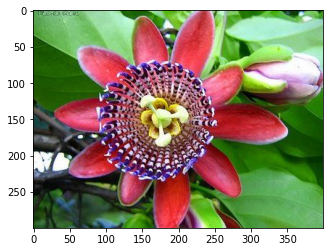

['A imagem provavelmente é: passion flower']


In [50]:
# url=input('Enter URL of Image :')
# url = './drive/MyDrive/Classroom/INF420/Projeto Final/teste_imagens/1.jpg'
url = 'teste_imagens/3.jpg'
img=imread(path + url )
img = imread(url)

plt.imshow(img)
plt.show()

img_resize = resize(img,(150,150,3))
l = [img_resize.flatten()]

print("A imagem provavelmente é: " + model.predict(l))  

# XGboost

## DMatrix

In [51]:
# Padronizar os rótulos

Y_ = Y.copy()
# categorias = ['passion flower', 'water lily', 'wallflower', 'petunia']
for i in range(Y_.shape[0]):
  if Y_[i] == 'passion flower':
    Y_[i] = 0
  elif Y_[i] == 'water lily':
    Y_[i] = 1
  elif Y_[i] == 'wallflower':
    Y_[i] = 2
  elif Y_[i] == 'petunia':
    Y_[i] = 3
# categorias = ['1', '2', '3', '4']



X_train, X_test, y_train, y_test = train_test_split(X, Y_, test_size = 0.2 , random_state = 42 )

In [52]:
if not XGbosst_treinado:
    xgb.set_config(verbosity=1)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)

In [54]:
if not XGbosst_treinado:
    # Modelo
    num_parallel_tree = 4
    num_boost_round = 16
    
    booster = xgb.train({
            'num_parallel_tree': num_parallel_tree, 
            'subsample': 0.5, 
            'num_class': 4
        },
        num_boost_round=num_boost_round,
        dtrain=dtrain,
    )

In [76]:
if not XGbosst_treinado:
  pickle.dump(booster,open(path + 'img_model_XGboost_treinado.p','wb'))
  print("Modelo salvo no drive")

else:
    if XGbosst_treinado:

      print("Modelo já treinado, usando o do drive")
      booster=pickle.load(open(path +'/img_model_XGboost_treinado.p','rb'))
      
      preds2 = booster.predict(dtest)
      accuracy = float(np.sum(preds2 == y_test)) / y_test.shape[0]
      print(f"O modelo tem {accuracy * 100}% acurácia")

    else:
      print("Modelo atualmente treinado")

Modelo já treinado, usando o do drive
O modelo tem 0.0% acurácia


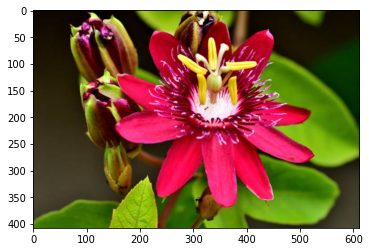

A imagem provavelmente é: petunia


In [63]:
# url=input('Enter URL of Image :')
url = 'teste_imagens/4.jpg'
# img=imread(path + url )
img = imread(url)

plt.imshow(img)
plt.show()

img_resize = resize(img,(150,150,3))
l = [img_resize.flatten()]
l = pd.DataFrame(l)
l = xgb.DMatrix(l)

print("A imagem provavelmente é: " +  categorias[int(booster.predict(l)[0])])

# Comparação

In [79]:
model_svm = model
model_xgboost = booster

In [80]:
y_pred=model_svm.predict(x_test)
print(f"O modelo SVM tem {accuracy_score(y_pred,y_test)*100}% acurácia")
preds2 = model_xgboost.predict(dtest)
accuracy = float(np.sum(preds2 == y_test)) / y_test.shape[0]
print(f"O modelo XGBoost tem {accuracy * 100}% acurácia")


O modelo SVM tem 86.11111111111111% acurácia
O modelo XGBoost tem 0.0% acurácia
